# Retinal Disease Detection

In this project we pull in data from [Kaggle Contest: VietAi Retinal Disease Detection](https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview)

- The dataset contains 3435 retinal images that represent multiple pathological disorders. The pathology classes and corresponding labels are: included in 'train.csv' file and each image can have more than one class category (multiple pathologies).
- The labels for each image are

```
-opacity (0), 
-diabetic retinopathy (1), 
-glaucoma (2),
-macular edema (3),
-macular degeneration (4),
-retinal vascular occlusion (5)
-normal (6)
```
- The test data set contains 350 unlabelled images.
- We are subsetting this dataset to train a classifier only on the classes "diabetic retinopathy", "glaucoma", "normal"

In [31]:
classes = ["diabetic retinopathy", "glaucoma", "normal"]

In [32]:
import pathlib 
import pandas as pd

DATA_DIR = pathlib.Path.cwd() / "data" / "train"

labels_df = pd.read_csv("data/train.csv")
labels_df["image_path"] = labels_df["filename"].apply(lambda x: str(DATA_DIR / x))

labels_df = labels_df[labels_df[classes].any(axis=1)]

### Train Test Split

- Stratified sampling to keep the class distribution similar in train and test
- 70/30 split

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
train_idx, test_idx = next(splitter.split(labels_df.image_path, labels_df[classes]))

In [15]:
X_train, y_train = labels_df.iloc[train_idx].image_path.values, labels_df.iloc[train_idx][classes].values
X_test, y_test = labels_df.iloc[test_idx].image_path.values, labels_df.iloc[test_idx][classes].values

### Data Augmentation

Using Keras preprocessing layers we can include data augmentation in our tf.data.Dataset definition.

Below I'm using random flips (horizontal and vertical) as well as random rotations up to $0.2\pi$

In [16]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

In [18]:
data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2, fill_mode="constant"),
])


In [19]:
IMG_SIZE = 512
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1024
NUM_CLASSES = len(classes)
AUTOTUNE = tf.data.experimental.AUTOTUNE

def parse_function(filename, channels=3):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=channels)
    return tf.keras.applications.resnet.preprocess_input(image_decoded)

def create_ds(X, y, is_training=True, augment=False):
    images = tf.data.Dataset.from_tensor_slices((X)).map(parse_function)
    labels = tf.data.Dataset.from_tensor_slices((y))
    dataset = tf.data.Dataset.zip((images, labels))
    
    if is_training:
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(
            buffer_size=SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True
        )

    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    
    if augment:
        # Apply data augmentation
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

### Example Augmentations

In [20]:
%matplotlib inline

def get_label_name(label):
    return classes[np.argmax(label)]

In [21]:
filename = X_train[0]
label = y_train[0]

In [22]:
preprocessed = parse_function(filename).numpy()
normal_jpeg = tf.image.decode_jpeg(tf.io.read_file(filename), channels=3).numpy()

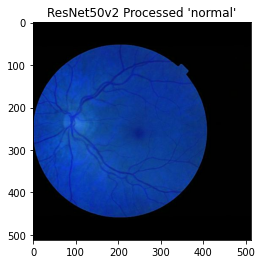

In [23]:
_ = plt.imshow(preprocessed)
_ = plt.title(f"ResNet50v2 Processed '{get_label_name(label)}'")

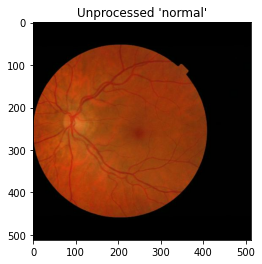

In [24]:
_ = plt.imshow(normal_jpeg)
_ = plt.title(f"Unprocessed '{get_label_name(label)}'")

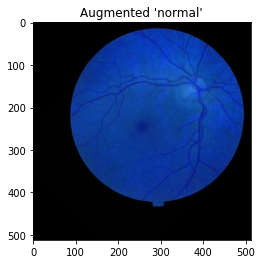

In [89]:
_ = plt.imshow(data_augmentation(preprocessed[np.newaxis, ...], training=True)[0])
_ = plt.title(f"Augmented '{get_label_name(label)}'")

### Create Datasets
- Do not augment test set

In [26]:
train_ds = create_ds(X_train, y_train, augment=True)
test_ds = create_ds(X_test, y_test, is_training=False)

In [27]:
LOAD_MODEL = False

In [34]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import Model

LR_INIT = 0.0002

if LOAD_MODEL:
    model = tf.keras.models.load_model("model.h5")
else:
    input_layer = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))
    resnet_backbone = ResNet50V2(include_top=False, input_tensor=input_layer, pooling=None)(input_layer)
    
    conv = tf.keras.layers.Conv2D(filters=128, kernel_size=4, strides=1, padding="valid")(resnet_backbone)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    
    hidden = tf.keras.layers.GlobalAveragePooling2D()(conv)
    hidden = tf.keras.layers.Dense(64, activation="relu")(hidden)
    hidden = tf.keras.layers.Flatten()(hidden)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(hidden)
    model = Model(inputs=input_layer, outputs=outputs)
    
    model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, name="binary_crossentropy"),
            optimizer=tf.keras.optimizers.Adam(learning_rate=LR_INIT),
            metrics=[
                    *[
                        tf.keras.metrics.Recall(
                            class_id=int(class_id), name=f"{name.replace(' ', '_')}_recall"
                        )
                        for class_id, name in enumerate(classes)
                    ],
                    *[
                        tf.keras.metrics.Precision(
                            class_id=int(class_id), name=f"{name.replace(' ', '_')}_precision"
                        )
                        for class_id, name in enumerate(classes)
                    ],
                    "accuracy",
                ],
        )

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 16, 16, 2048)      23564800  
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 128)       4194432   
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 13, 13, 128)       0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256  

In [37]:
EPOCHS = 70

if not LOAD_MODEL:
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        verbose=1,
        patience=20,
        mode="max",
        restore_best_weights=True,
    )
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir="logs",
        histogram_freq=0,
        write_graph=True,
        write_images=False,
        update_freq="epoch",
        profile_batch=2,
        embeddings_freq=0,
        embeddings_metadata=None,
    )


    H = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping, tensorboard], verbose=1)
    model.save(filepath="model.h5")

Epoch 1/70
41/41 [==============================] - 65s 1s/step - loss: 0.1924 - diabetic_retinopathy_recall: 0.8864 - glaucoma_recall: 0.8206 - normal_recall: 0.9183 - diabetic_retinopathy_precision: 0.8880 - glaucoma_precision: 0.8469 - normal_precision: 0.9656 - accuracy: 0.8885 - val_loss: 0.4512 - val_diabetic_retinopathy_recall: 0.9559 - val_glaucoma_recall: 0.6034 - val_normal_recall: 0.4051 - val_diabetic_retinopathy_precision: 0.6290 - val_glaucoma_precision: 0.8120 - val_normal_precision: 0.9412 - val_accuracy: 0.6900
Epoch 2/70
41/41 [==============================] - 64s 1s/step - loss: 0.1744 - diabetic_retinopathy_recall: 0.8845 - glaucoma_recall: 0.8565 - normal_recall: 0.9264 - diabetic_retinopathy_precision: 0.9103 - glaucoma_precision: 0.8565 - normal_precision: 0.9471 - accuracy: 0.8892 - val_loss: 0.3524 - val_diabetic_retinopathy_recall: 0.5551 - val_glaucoma_recall: 0.9497 - val_normal_recall: 0.8861 - val_diabetic_retinopathy_precision: 0.9545 - val_glaucoma_prec

In [45]:
model.layers[1].trainable = False
model.optimizer.lr = 0.0001
H_finetune = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping, tensorboard], verbose=1)
model.save(filepath="fine_tunes.h5")

Epoch 1/70
41/41 [==============================] - 65s 1s/step - loss: 0.0252 - diabetic_retinopathy_recall: 0.9867 - glaucoma_recall: 0.9856 - normal_recall: 0.9973 - diabetic_retinopathy_precision: 0.9905 - glaucoma_precision: 0.9904 - normal_precision: 0.9946 - accuracy: 0.9885 - val_loss: 0.3038 - val_diabetic_retinopathy_recall: 0.8634 - val_glaucoma_recall: 0.7263 - val_normal_recall: 0.9873 - val_diabetic_retinopathy_precision: 0.9423 - val_glaucoma_precision: 0.8725 - val_normal_precision: 0.8000 - val_accuracy: 0.8566
Epoch 2/70
41/41 [==============================] - 64s 1s/step - loss: 0.0316 - diabetic_retinopathy_recall: 0.9811 - glaucoma_recall: 0.9856 - normal_recall: 0.9946 - diabetic_retinopathy_precision: 0.9923 - glaucoma_precision: 0.9786 - normal_precision: 0.9918 - accuracy: 0.9815 - val_loss: 0.2319 - val_diabetic_retinopathy_recall: 0.9119 - val_glaucoma_recall: 0.7374 - val_normal_recall: 0.9557 - val_diabetic_retinopathy_precision: 0.9000 - val_glaucoma_prec

In [46]:
metrics = model.evaluate(x=test_ds)

18/18 [==============================] - 7s 353ms/step - loss: 0.2155 - diabetic_retinopathy_recall: 0.9163 - glaucoma_recall: 0.8156 - normal_recall: 0.9430 - diabetic_retinopathy_precision: 0.8966 - glaucoma_precision: 0.8957 - normal_precision: 0.9030 - accuracy: 0.8943


## Architecture and Parameter Selection 

### Architecture

- ResNet50 Backbone using imagenet features
- Passing the last convolutional output of the ResNet50 backbone to my own convolutional layer to aid feature visualization
- GlobalAverage pooling to take into combine local features prior to final classification and serve as a feature_vector

### Data Augmentation

- I randomly flip and rotate these images in the tf.data.Dataset so the model never sees the same exact image (regularization strategy)

### Training Procedure

- Train the whole network with EarlyStopping using lr==0.0002
- Cut learning rate in half and freeze top layers, leaving the final convolutional layers and dense layers to fine tune for more epochs (30 in my case)


### Training and Validation Curves 

In [48]:
def plot_history(H):
    plt.plot(H.history['accuracy'])
    plt.plot(H.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(H.history['loss'])
    plt.plot(H.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

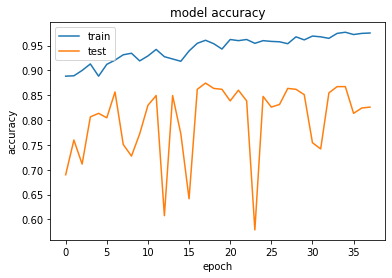

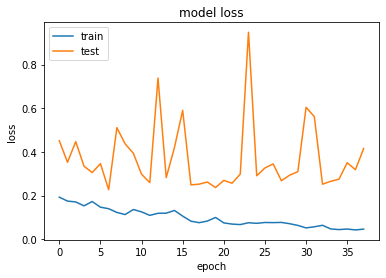

In [49]:
plot_history(H)

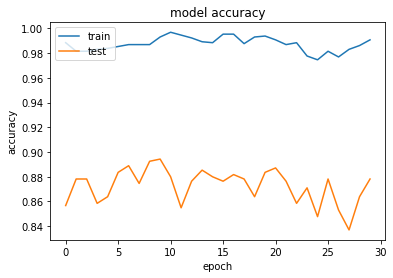

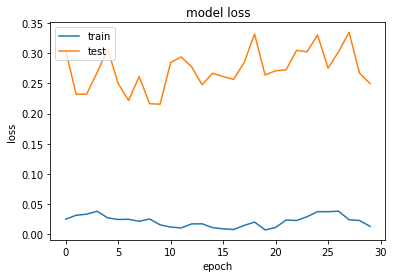

In [47]:
plot_history(H_finetune)

## Visual Feature Heatmaps by class
- Using tf-explain's implementation of [Grad-CAM](https://arxiv.org/abs/1610.02391)
- Understand "where the model is looking" to spot Glaucoma and DR


In [50]:
import cv2
from tensorflow.keras import Model
from tf_explain.core.grad_cam import GradCAM

glaucoma_sample_images = labels_df[labels_df["glaucoma"] == 1].image_path.sample(5).values
diabetic_retinopathy_sample_images = labels_df[labels_df["diabetic retinopathy"] == 1].image_path.sample(5).values

def generate_and_save_grad_cam(imgs: list, class_name: str):
    for i, img in enumerate(imgs):
        img = parse_function(img)
        data = ([img.numpy()], None)
        # Start explainer
        explainer = GradCAM()
        class_index = classes.index(class_name)
        grid = explainer.explain(data, model, class_index=class_index, layer_name=model.layers[2].name)
        output_dir = class_name.replace(' ', '_')
        explainer.save(grid, f"./images/{output_dir}", f"grad_{i}.png")
        cv2.imwrite(f'./images/{output_dir}/original_{i}.jpg', img.numpy())

In [51]:
generate_and_save_grad_cam(glaucoma_sample_images, class_name="glaucoma")

In [52]:
generate_and_save_grad_cam(diabetic_retinopathy_sample_images, class_name="diabetic retinopathy")

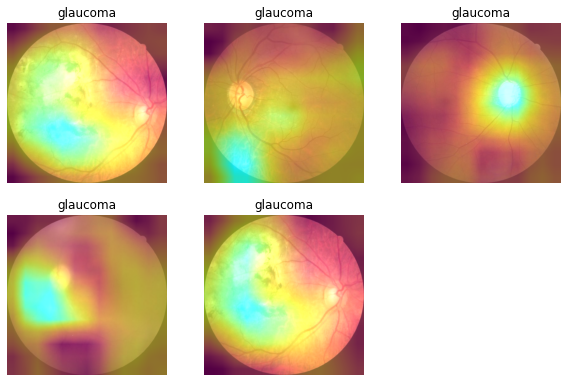

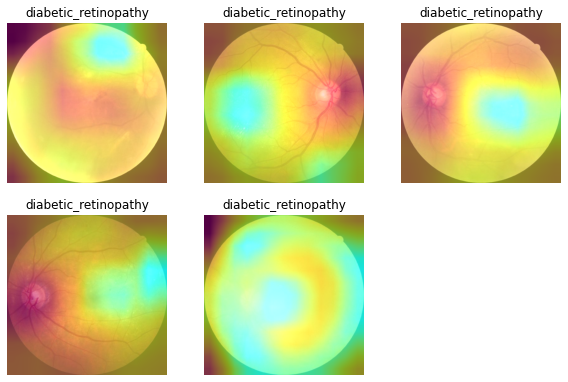

In [92]:
for class_name in ["glaucoma", "diabetic_retinopathy"]:
    plt.figure(figsize=(10, 10))
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        filename = f"./images/{class_name}/grad_{i}.png"
        img = cv2.imread(filename)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")


**Based on the visualization, the model is focusing on brighter areas, looking at the “cloudier” part of the retina rather than the veins**

## Label Propagation

- Train a model using the 'train' split.
- Pass the unlabelled images through the trained model and retrieve the dense layer feature prior to classification layer. Using this dense layer as representative of the image, apply label propagation to retrieve labels correspndng to the unbalelled data.
- Concatenate the train data with the unlabelled data (that has now been self labelled) and retrain the network.
- Hopefully, we see an improvement in performance on our heldout set!

In [53]:
UNLABELED_DATA_DIR = pathlib.Path.cwd() / "data" / "test"

unlabeled_images = tf.data.Dataset.from_tensor_slices(([str(p) for p in UNLABELED_DATA_DIR.glob("*.jpg")]))
unlabeled_ds = unlabeled_images.map(parse_function).batch(BATCH_SIZE)

In [54]:
for img in unlabeled_ds.take(1):
    print(img.shape)

(32, 512, 512, 3)


In [61]:
label_propagation = model.predict(x=unlabeled_ds)

In [69]:
lp_ds = tf.cast(tf.math.round(label_propagation), tf.int64)

In [73]:
label_ds = tf.data.Dataset.from_tensor_slices(lp_ds)
propagated_ds = tf.data.Dataset.zip((unlabeled_ds.unbatch(), label_ds)).batch(BATCH_SIZE)
propagated_ds = propagated_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

In [74]:
lp_train_ds = tf.data.Dataset.concatenate(propagated_ds, train_ds)

In [75]:
H_propagate = model.fit(lp_train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping], verbose=1)

Epoch 1/70
52/52 [==============================] - 39s 740ms/step - loss: 0.0490 - diabetic_retinopathy_recall: 0.9684 - glaucoma_recall: 0.9635 - normal_recall: 0.9858 - diabetic_retinopathy_precision: 0.9751 - glaucoma_precision: 0.9617 - normal_precision: 0.9882 - accuracy: 0.9685 - val_loss: 0.2339 - val_diabetic_retinopathy_recall: 0.9471 - val_glaucoma_recall: 0.7821 - val_normal_recall: 0.9304 - val_diabetic_retinopathy_precision: 0.8811 - val_glaucoma_precision: 0.9091 - val_normal_precision: 0.9130 - val_accuracy: 0.8943
Epoch 2/70
52/52 [==============================] - 39s 730ms/step - loss: 0.0434 - diabetic_retinopathy_recall: 0.9670 - glaucoma_recall: 0.9712 - normal_recall: 0.9882 - diabetic_retinopathy_precision: 0.9764 - glaucoma_precision: 0.9602 - normal_precision: 0.9882 - accuracy: 0.9715 - val_loss: 0.2329 - val_diabetic_retinopathy_recall: 0.9471 - val_glaucoma_recall: 0.7821 - val_normal_recall: 0.9304 - val_diabetic_retinopathy_precision: 0.8811 - val_glaucom

In [77]:
metrics = model.evaluate(x=test_ds)

18/18 [==============================] - 7s 345ms/step - loss: 0.2373 - diabetic_retinopathy_recall: 0.9339 - glaucoma_recall: 0.8101 - normal_recall: 0.9494 - diabetic_retinopathy_precision: 0.9060 - glaucoma_precision: 0.8951 - normal_precision: 0.9036 - accuracy: 0.9050


In [78]:
model.save("propagated.h5")

In [79]:
metrics

[0.2372925728559494,
 0.933920681476593,
 0.8100558519363403,
 0.949367105960846,
 0.9059829115867615,
 0.895061731338501,
 0.9036144614219666,
 0.9050179123878479]

After running label propagation we see a nice accuracy improvement 89.4% -> 90.5%